In [38]:
# Import our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler,OneHotEncoder
import pandas as pd
import tensorflow as tf
# Import checkpoint dependencies
import os
from tensorflow.keras.callbacks import ModelCheckpoint

#  read in the charity_data.csv to a Pandas DataFrame.
import pandas as pd 
application_df = pd.read_csv("charity_data.csv")
application_df.head()

,EIN,NAME,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,10520599,BLUE KNIGHTS MOTORCYCLE CLUB,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,10531628,AMERICAN CHESAPEAKE CLUB CHARITABLE TR,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,10547893,ST CLOUD PROFESSIONAL FIREFIGHTERS,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,10553066,SOUTHSIDE ATHLETIC ASSOCIATION,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,10556103,GENETIC RESEARCH INSTITUTE OF THE DESERT,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


# Preprocessing the Data for a Neural Network (Deliverable 1)
Preprocess the dataset like you did in Deliverable 1, taking into account any modifications to optimize the model.

In [39]:
# Drop the non-beneficial ID columns, 'EIN' and 'NAME'.
application_df = application_df.drop(columns=["EIN", "NAME"], axis=1)
application_df.head()

,APPLICATION_TYPE,AFFILIATION,CLASSIFICATION,USE_CASE,ORGANIZATION,STATUS,INCOME_AMT,SPECIAL_CONSIDERATIONS,ASK_AMT,IS_SUCCESSFUL
0,T10,Independent,C1000,ProductDev,Association,1,0,N,5000,1
1,T3,Independent,C2000,Preservation,Co-operative,1,1-9999,N,108590,1
2,T5,CompanySponsored,C3000,ProductDev,Association,1,0,N,5000,0
3,T3,CompanySponsored,C2000,Preservation,Trust,1,10000-24999,N,6692,1
4,T3,Independent,C1000,Heathcare,Trust,1,100000-499999,N,142590,1


In [40]:
# Determine the number of unique values in each column.
application_df.nunique()

APPLICATION_TYPE            17
AFFILIATION                  6
CLASSIFICATION              71
USE_CASE                     5
ORGANIZATION                 4
STATUS                       2
INCOME_AMT                   9
SPECIAL_CONSIDERATIONS       2
ASK_AMT                   8747
IS_SUCCESSFUL                2
dtype: int64

In [41]:
ask_amt_counts = application_df.ASK_AMT.value_counts()
ask_amt_counts

5000       25398
15583          3
6725           3
63981          3
10478          3
           ...  
75598          1
22336          1
44863          1
5928           1
6948863        1
Name: ASK_AMT, Length: 8747, dtype: int64

<AxesSubplot:ylabel='Density'>

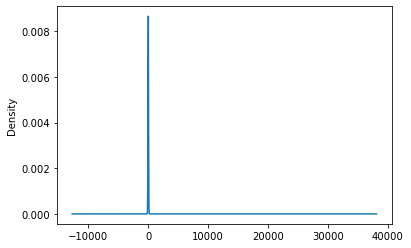

In [42]:
ask_amt_counts.plot.density()

In [43]:
# Determine which values to replace if counts are less than ...?
replace_ask_amt = list(ask_amt_counts[ask_amt_counts < 1000].index)

# Replace in dataframe
for amt in replace_ask_amt:
    if amt <= 49999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5001-49999"))
    elif amt < 99999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("50000-99999"))
    elif amt < 499999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("100000-499999"))
    elif amt < 999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("500000-999999"))
    elif amt < 4999999:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("1M-5M"))
    else:
        application_df.ASK_AMT = application_df.ASK_AMT.replace(amt,str("5M+"))
    
application_df.ASK_AMT = application_df.ASK_AMT.astype(str)

# Check to make sure binning was successful
application_df.ASK_AMT.value_counts()

5000             25398
5001-49999        2947
100000-499999     2305
50000-99999       1421
1M-5M              940
500000-999999      651
5M+                637
Name: ASK_AMT, dtype: int64

In [44]:
application_counts = application_df.APPLICATION_TYPE.value_counts()
application_counts

T3     27037
T4      1542
T6      1216
T5      1173
T19     1065
T8       737
T7       725
T10      528
T9       156
T13       66
T12       27
T2        16
T14        3
T25        3
T15        2
T29        2
T17        1
Name: APPLICATION_TYPE, dtype: int64

<AxesSubplot:ylabel='Density'>

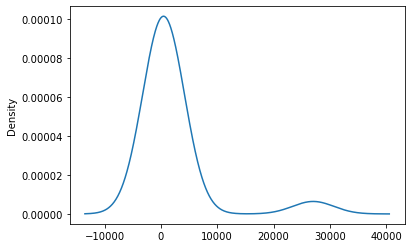

In [45]:
application_counts.plot.density()

In [46]:
# Determine which values to replace if counts are less than ...?
replace_application = list(application_counts[application_counts < 500].index)

# Replace in dataframe
for app in replace_application:
    application_df.APPLICATION_TYPE = application_df.APPLICATION_TYPE.replace(app,"Other")
    
# Check to make sure binning was successful
application_df.APPLICATION_TYPE.value_counts()

T3       27037
T4        1542
T6        1216
T5        1173
T19       1065
T8         737
T7         725
T10        528
Other      276
Name: APPLICATION_TYPE, dtype: int64

In [47]:
classification_counts = application_df.CLASSIFICATION.value_counts()
classification_counts

C1000    17326
C2000     6074
C1200     4837
C3000     1918
C2100     1883
         ...  
C1370        1
C3700        1
C2570        1
C2150        1
C4200        1
Name: CLASSIFICATION, Length: 71, dtype: int64

In [48]:
# Determine which values to replace if counts are less than ..?
replace_class = list(classification_counts[classification_counts < 1000].index)

# Replace in dataframe
for cls in replace_class:
    application_df.CLASSIFICATION = application_df.CLASSIFICATION.replace(cls,"Other")
    
# Check to make sure binning was successful
application_df.CLASSIFICATION.value_counts()

C1000    17326
C2000     6074
C1200     4837
Other     2261
C3000     1918
C2100     1883
Name: CLASSIFICATION, dtype: int64

In [49]:
# Generate our categorical variable lists
application_cat = ["APPLICATION_TYPE", "AFFILIATION", "CLASSIFICATION", "USE_CASE", "ORGANIZATION", "INCOME_AMT", 
                  "SPECIAL_CONSIDERATIONS", "ASK_AMT"]

In [50]:
# Create a OneHotEncoder instance
enc = OneHotEncoder(sparse=False)

# Fit and transform the OneHotEncoder using the categorical variable list
encode_df = pd.DataFrame(enc.fit_transform(application_df[application_cat]))

# Add the encoded variable names to the dataframe
encode_df.columns = enc.get_feature_names(application_cat)
encode_df.head()

,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,APPLICATION_TYPE_T8,AFFILIATION_CompanySponsored,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [51]:
# Merge one-hot encoded features and drop the originals
application_df = application_df.merge(encode_df, left_index=True, right_index=True).drop(columns=application_cat, axis=1)
application_df.head()

,STATUS,IS_SUCCESSFUL,APPLICATION_TYPE_Other,APPLICATION_TYPE_T10,APPLICATION_TYPE_T19,APPLICATION_TYPE_T3,APPLICATION_TYPE_T4,APPLICATION_TYPE_T5,APPLICATION_TYPE_T6,APPLICATION_TYPE_T7,...,INCOME_AMT_5M-10M,SPECIAL_CONSIDERATIONS_N,SPECIAL_CONSIDERATIONS_Y,ASK_AMT_100000-499999,ASK_AMT_1M-5M,ASK_AMT_5000,ASK_AMT_50000-99999,ASK_AMT_500000-999999,ASK_AMT_5001-49999,ASK_AMT_5M+
0,1,1,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1,0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,1,1,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
y = application_df.IS_SUCCESSFUL
X = application_df.drop("IS_SUCCESSFUL", axis=1)

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=0, stratify=y)

In [53]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Adding more neurons to a hidden layer

In [54]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 100
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_10 (Dense)            (None, 100)               5000      
                                                                 
 dense_11 (Dense)            (None, 30)                3030      
                                                                 
 dense_12 (Dense)            (None, 1)                 31        
                                                                 
Total params: 8,061
Trainable params: 8,061
Non-trainable params: 0
_________________________________________________________________


In [55]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [56]:
os.makedirs("checkpoints_optimization_add_neurons/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_neurons/weights.{epoch:02d}hdf5"

In [57]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback])

Epoch 1/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5714 - accuracy: 0.7196
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5546 - accuracy: 0.7286
Epoch 3/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5512 - accuracy: 0.7309
Epoch 4/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5482 - accuracy: 0.7313
Epoch 5/100
804/804 [==============================] - 1s 1ms/step - loss: 0.5478 - accuracy: 0.7318
Epoch 6/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5463 - accuracy: 0.7327
Epoch 7/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5445 - accuracy: 0.7317
Epoch 8/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5442 - accuracy: 0.7346
Epoch 9/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5426 - accuracy: 0.7345
Epoch 10/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5423 - accura

804/804 [==============================] - 2s 3ms/step - loss: 0.5256 - accuracy: 0.7435
Epoch 81/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5256 - accuracy: 0.7442
Epoch 82/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5255 - accuracy: 0.7429
Epoch 83/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5247 - accuracy: 0.7452
Epoch 84/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5250 - accuracy: 0.7449
Epoch 85/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5251 - accuracy: 0.7444
Epoch 86/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5251 - accuracy: 0.7432
Epoch 87/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5251 - accuracy: 0.7446
Epoch 88/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5243 - accuracy: 0.7438
Epoch 89/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5249 - accuracy: 

In [58]:
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5698 - accuracy: 0.7289 - 403ms/epoch - 2ms/step
Loss: 0.5698223114013672, Accuracy: 0.728863000869751


# More Hidden Layers

In [59]:
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 80
nodes_hidden_layer2 = 30
nodes_hidden_layer3 = 10

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="relu", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="relu"))

# Third hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer3, activation="relu"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_13 (Dense)            (None, 80)                4000      
                                                                 
 dense_14 (Dense)            (None, 30)                2430      
                                                                 
 dense_15 (Dense)            (None, 10)                310       
                                                                 
 dense_16 (Dense)            (None, 1)                 11        
                                                                 
Total params: 6,751
Trainable params: 6,751
Non-trainable params: 0
_________________________________________________________________


In [60]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [61]:
os.makedirs("checkpoints_optimization_add_layer/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_add_layer/weights.{epoch:02d}hdf5"

In [62]:
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=100, callbacks=[cp_callback], verbose=1)

Epoch 1/100
804/804 [==============================] - 2s 1ms/step - loss: 0.5716 - accuracy: 0.7180
Epoch 2/100
804/804 [==============================] - 1s 2ms/step - loss: 0.5553 - accuracy: 0.7271
Epoch 3/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5504 - accuracy: 0.7313
Epoch 4/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5481 - accuracy: 0.7304
Epoch 5/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5466 - accuracy: 0.7334
Epoch 6/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5451 - accuracy: 0.7332
Epoch 7/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5449 - accuracy: 0.7339
Epoch 8/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5441 - accuracy: 0.7354
Epoch 9/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5426 - accuracy: 0.7353
Epoch 10/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5417 - accura

804/804 [==============================] - 2s 3ms/step - loss: 0.5247 - accuracy: 0.7444
Epoch 80/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5248 - accuracy: 0.7446
Epoch 81/100
804/804 [==============================] - 3s 4ms/step - loss: 0.5247 - accuracy: 0.7442
Epoch 82/100
804/804 [==============================] - 3s 3ms/step - loss: 0.5247 - accuracy: 0.7450
Epoch 83/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5244 - accuracy: 0.7449
Epoch 84/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5249 - accuracy: 0.7447
Epoch 85/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5252 - accuracy: 0.7437
Epoch 86/100
804/804 [==============================] - 2s 2ms/step - loss: 0.5246 - accuracy: 0.7440
Epoch 87/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5243 - accuracy: 0.7452
Epoch 88/100
804/804 [==============================] - 2s 3ms/step - loss: 0.5239 - accuracy: 

In [63]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5676 - accuracy: 0.7304 - 419ms/epoch - 2ms/step
Loss: 0.5676087737083435, Accuracy: 0.7303789854049683


# Use different activation functions for the hidden layers

In [126]:
number_input_features = len(X_train_scaled[0])
nodes_hidden_layer1 = 80
nodes_hidden_layer2 = 30

nn = tf.keras.models.Sequential()

# First hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer1, activation="tanh", input_dim=number_input_features))

# Second hidden layer
nn.add(tf.keras.layers.Dense(units=nodes_hidden_layer2, activation="tanh"))

# Output layer
nn.add(tf.keras.layers.Dense(units=1, activation="sigmoid"))

# Check the structure of the model
nn.summary()

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_44 (Dense)            (None, 80)                4000      
                                                                 
 dense_45 (Dense)            (None, 30)                2430      
                                                                 
 dense_46 (Dense)            (None, 1)                 31        
                                                                 
Total params: 6,461
Trainable params: 6,461
Non-trainable params: 0
_________________________________________________________________


In [127]:
nn.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

In [128]:
os.makedirs("checkpoints_optimization_change_activ/", exist_ok=True)
checkpoint_path = "checkpoints_optimization_change_activ/weights.{epoch:02d}hdf5"

In [129]:
# Create a callback that saves the model's weights every 5 epochs
cp_callback = ModelCheckpoint(
    filepath=checkpoint_path,
    verbose=0,
    save_weights_only=True,
    save_freq='epoch',
    period=5)

# Train the model
fit_model = nn.fit(X_train_scaled, y_train, epochs=120, callbacks=[cp_callback], verbose=1)

Epoch 1/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5726 - accuracy: 0.7165
Epoch 2/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5558 - accuracy: 0.7264
Epoch 3/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5514 - accuracy: 0.7277
Epoch 4/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5489 - accuracy: 0.7304
Epoch 5/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5472 - accuracy: 0.7317
Epoch 6/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5460 - accuracy: 0.7325
Epoch 7/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5456 - accuracy: 0.7326
Epoch 8/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5438 - accuracy: 0.7341
Epoch 9/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5436 - accuracy: 0.7334
Epoch 10/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5419 - accura

804/804 [==============================] - 1s 1ms/step - loss: 0.5226 - accuracy: 0.7456
Epoch 80/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5226 - accuracy: 0.7450
Epoch 81/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5226 - accuracy: 0.7444
Epoch 82/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5224 - accuracy: 0.7456
Epoch 83/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5222 - accuracy: 0.7455
Epoch 84/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5224 - accuracy: 0.7448
Epoch 85/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5223 - accuracy: 0.7459
Epoch 86/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5218 - accuracy: 0.7453
Epoch 87/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5218 - accuracy: 0.7454
Epoch 88/120
804/804 [==============================] - 1s 1ms/step - loss: 0.5217 - accuracy: 

In [130]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

268/268 - 0s - loss: 0.5651 - accuracy: 0.7256 - 296ms/epoch - 1ms/step
Loss: 0.5650948286056519, Accuracy: 0.7255976796150208


In [131]:
# Export our model to HDF5 file
nn.save("AlphabetSoupCharity_Optimization.h5")